# Homework 3 of ys3031, EECS 6894

# Problem 1

Our topic is "Reseach on data augmentation with deep neural networks". Data Augmentation is a very efficient way to enrich the traning and testing dataset when a very limited dataset only is accessible. 

In this project, we would like to implement the idea of this paper (https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf). Say we are training a model that predicts which artist a specific painting is composed of. We would compare the model that trained on (1) limited dataset, with only several painting for each artist and (2) expanded dataset augmented by the paper mentioned above.

# Problem 2

In [ ]:
import keras 
model = keras.applications.resnet50.ResNet50(include_top=True,
                                            weights='imagenet',
                                            input_tensor=None,
                                            input_shape=None,
                                            pooling=None,
                                            classes=1000)

In [ ]:
model.summary()

In [ ]:
# 
conv1=9472+256

#
conv2a=4160+256+36928+256+16640+16640+1024+1024

#
conv2b=16448+256+36928+256+16640+1024 
conv2c=16448+256+36928+256+16640+1024

#
conv3a=32896+512+147584+512+66048+131584+2048+2048

#
conv3b=65664+512+147584+512+66048+2048
conv3c=65664+512+147584+512+66048+2048                                                                 
conv3d=65664+512+147584+512+66048+2048

#
conv4a=131328+1024+590080+1024+263168+525312+4096+4096

#
conv4b=262400+1024+590080+1024+263168+4096
conv4c=262400+1024+590080+1024+263168+4096                                                                 
conv4d=262400+1024+590080+1024+263168+4096
conv4e=262400+1024+590080+1024+263168+4096
conv4f=262400+1024+590080+1024+263168+4096

#
conv5a=524800+2048+2359808+2048+1050624+2099200+8192+8192

#
conv5b=1049088+2048+2359808+2048+1050624+8192                                                                 
conv5c=1049088+2048+2359808+2048+1050624+8192

#
convfc=2049000

conv2 = conv2a+conv2b+conv2c
conv3 = conv3a+conv3b+conv3c+conv3c
conv4 = conv4a+conv4b+conv4c+conv4d+conv4e+conv4f
conv5 = conv5a+conv5b+conv5c

print("conv1:", conv1)
print("conv2:", conv2)
print("conv3:", conv3)
print("conv4:", conv4)
print("conv5:", conv5)

print(conv1+conv2a+conv2b+conv2c+conv3a+conv3b+conv3c+conv3d+conv4a+conv4b+conv4c+conv4d+conv4e+conv4f+conv5a+conv5b+conv5c+convfc)

# Problem 3

In [27]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.vgg16 import VGG16
import os

def data_aug(category, starname):
    for filename in os.listdir(os.path.join("data_origin", category, starname)):
        if filename.endswith(".jpg"):
            filenameandpath = os.path.join("data_origin", category, starname, filename)
            print(filenameandpath)
            img = load_img(os.path.join("data_origin", category, starname, filename))
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)
            i = 0
            datagen = ImageDataGenerator(
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')
            for _ in datagen.flow(img_array, 
                                  batch_size=1, 
                                  save_to_dir=os.path.join("data_expanded", category, starname), 
                                  save_prefix=starname, 
                                  save_format="jpeg"):
                i += 1
                if i > 50:
                    break
                    
data_aug("train", "jennifer")
data_aug("validation", "jennifer")
data_aug("train", "justin")
data_aug("validation", "justin")

data_origin/train/jennifer/1-FaceId-0.jpg
data_origin/train/jennifer/6-FaceId-0.jpg
data_origin/train/jennifer/7-FaceId-0.jpg
data_origin/train/jennifer/2-FaceId-0.jpg
data_origin/train/jennifer/5-FaceId-0.jpg
data_origin/train/jennifer/10-FaceId-0.jpg
data_origin/train/jennifer/4-FaceId-0.jpg
data_origin/train/jennifer/3-FaceId-0.jpg
data_origin/train/jennifer/9-FaceId-0.jpg
data_origin/train/jennifer/8-FaceId-0.jpg
data_origin/validation/jennifer/19-FaceId-0.jpg
data_origin/validation/jennifer/18-FaceId-0.jpg
data_origin/validation/jennifer/12-FaceId-0.jpg
data_origin/validation/jennifer/15-FaceId-0.jpg
data_origin/validation/jennifer/14-FaceId-0.jpg
data_origin/validation/jennifer/13-FaceId-0.jpg
data_origin/validation/jennifer/11-FaceId-0.jpg
data_origin/validation/jennifer/16-FaceId-0.jpg
data_origin/validation/jennifer/20-FaceId-0.jpg
data_origin/validation/jennifer/17-FaceId-0.jpg
data_origin/train/justin/1-FaceId-0.jpg
data_origin/train/justin/6-FaceId-0.jpg
data_origin/train/j

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras import regularizers

img_width, img_height = 224, 224

train_data_dir = 'data_expanded/train'
validation_data_dir = 'data_expanded/validation'
epochs = 6
batch_size = 20

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


model_vgg = VGG16(input_shape=input_shape, include_top=False)

model = Sequential()

model.add(model_vgg)
top_model = Sequential()
top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
top_model.add(Dense(256))
top_model.add(Activation('relu'))
top_model.add(Dropout(0.8))
top_model.add(Dense(2))
top_model.add(Activation('softmax'))

model.add(top_model)

model.layers[0].trainable = False 

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.fit_generator(
        train_generator,
        steps_per_epoch=500 // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=200 // batch_size)

top_model.save_weights("./vgg16_top_model.h5")

Found 1937 images belonging to 2 classes.
Found 2126 images belonging to 2 classes.
Epoch 1/6
25/25 [==============================] - 161s 6s/step - loss: 3.7217 - acc: 0.5800 - val_loss: 0.2085 - val_acc: 0.9050
Epoch 2/6
25/25 [==============================] - 160s 6s/step - loss: 1.2669 - acc: 0.7560 - val_loss: 0.1724 - val_acc: 0.9150
Epoch 3/6
25/25 [==============================] - 159s 6s/step - loss: 0.2975 - acc: 0.8753 - val_loss: 0.3293 - val_acc: 0.8700
Epoch 4/6
25/25 [==============================] - 160s 6s/step - loss: 0.3419 - acc: 0.8640 - val_loss: 0.1457 - val_acc: 0.9500
Epoch 5/6
25/25 [==============================] - 160s 6s/step - loss: 0.2199 - acc: 0.9000 - val_loss: 0.1393 - val_acc: 0.9300
Epoch 6/6
25/25 [==============================] - 160s 6s/step - loss: 0.1713 - acc: 0.9176 - val_loss: 0.1585 - val_acc: 0.9250


In [4]:
from keras.preprocessing.image import load_img, img_to_array, array_to_img

def predict_jennifer_or_justin(img_path):
    img_selfie = load_img(img_path, target_size=(224, 224))
    selfie_array = img_to_array(img_selfie)
    selfie_array = selfie_array.reshape((1,) + selfie_array.shape)
    selfie_array /= 255.0
    result = model.predict_classes(selfie_array)
    print(result)

In [5]:
predict_jennifer_or_justin('./selfie/sunyiming.jpeg')
predict_jennifer_or_justin('./selfie/justin.jpeg')
predict_jennifer_or_justin('./selfie/jennifer.jpeg')

[1]
[1]
[0]


# Problem 4

1111
1212
1313
2222
[4.07731   2.4754176]
[1.6984383 6.803513 ]
0
1
3333


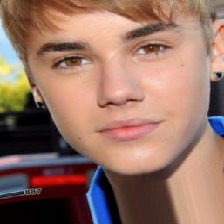

In [8]:
import foolbox
from foolbox.models import KerasModel
from foolbox.attacks import LBFGSAttack
from foolbox.criteria import TargetClassProbability
from keras import backend
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import numpy as np

backend.set_learning_phase(0)
path = './selfie/justin.jpeg'

jennifer_image = load_img(path, target_size=(224,224))
jennifer_array = img_to_array(jennifer_image)
jennifer_array = jennifer_array / 255.0
label = 1

preprocessing = (np.array([104/255.0, 116/255.0, 123/ 255.0]), 1)
fmodel = KerasModel(model, bounds=(0, 1), preprocessing=preprocessing)
attack = LBFGSAttack(model=fmodel, criterion=TargetClassProbability(0, p=0.8))
adver_jennifer_array = attack(jennifer_array, label)

print(fmodel.predictions(adver_jennifer_array))
print(fmodel.predictions(jennifer_array))
print(np.argmax(fmodel.predictions(adver_jennifer_array)))
print(np.argmax(fmodel.predictions(jennifer_array)))

adver_jennifer_image = array_to_img(adver_jennifer_array)
adver_jennifer_image



# model.predict_classes(jennifer_array.reshape((1,)+jennifer_array.shape))


In [ ]:
print(type(adversarial), adversarial.shape, je_array.shape)

In [ ]:
je_array_reshaped = je_array.reshape((1,) + je_array.shape)
adversarial_reshaped = adversarial.reshape((1,) + adversarial.shape)
print(model.predict_classes(je_array_reshaped))
print(model.predict_classes(adversarial_reshaped))